In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy



from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve

import time

# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
             "log_probability_2flares2ars": 10 # two flares, two active regions
            }



# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())




/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/resources.py:107: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/_sri.json' mode='r' encoding='UTF-8'>
  _SRI_HASHES = json.load(open(join(ROOT_DIR, "_sri.json")))
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [3]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 2
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma


In [4]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.6) & (t < target.view_stop-.25) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

FileNotFoundError: [Errno 2] No such file or directory: '/home/ekaterina/Documents/001_science/MalachiteMountains/data/lcs/44984200_10_tess_slc_custom.fits'

In [1]:
len(phi)

NameError: name 'phi' is not defined

<ErrorbarContainer object of 3 artists>

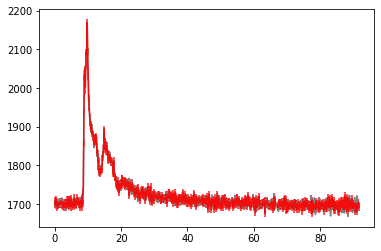

In [72]:
cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.plot(cf.phi, cf.flux,color="grey")
plt.errorbar(cff.phi, cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
#plt.xlim(25,30)

In [73]:
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0917, 0.102]",0.038613,1704.102500,1587.850801,8.676423,1687.235558
"(0.102, 0.204]",0.154452,1708.601230,1587.852884,8.676423,1687.235558
"(0.204, 0.306]",0.231678,1698.012232,1587.854273,8.676423,1687.235558
"(0.306, 0.407]",0.347517,1695.328419,1587.856356,8.676423,1687.235558
"(0.407, 0.509]",0.463355,1711.745560,1587.858440,8.676423,1687.235558
...,...,...,...,...,...
"(91.158, 91.26]",91.203740,1702.081069,1589.490361,8.676423,1687.235558
"(91.26, 91.362]",91.319579,1702.679018,1589.492444,8.676423,1687.235558
"(91.362, 91.463]",91.435418,1704.158458,1589.494527,8.676423,1687.235558


In [75]:
cff.dropna(how="any").to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

1687.2355579010703

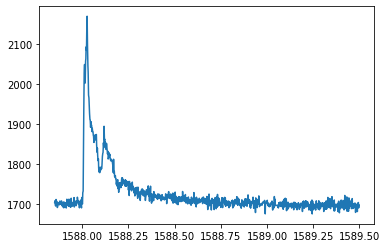

In [76]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(lc.t, lc.flux)

In [77]:
tstamp

'08_07_2020_11_48'

(1600.0, 2250.0)

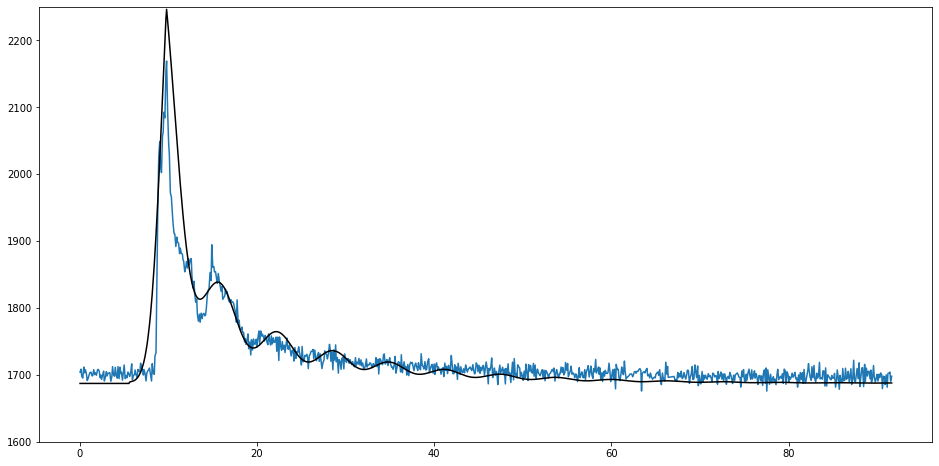

In [97]:

phi_a =9.8
theta_a = 65*np.pi/180#target.theta_a_init
a = .34
fwhm =  .15/target.Prot_d * 2 * np.pi
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = -150* np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
# for i in range(-180,180,10):
#     plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i* np.pi / 180,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(1600,2250)

In [ ]:








### Save inits

In [98]:



# 
log_prob = "log_probability"
nparam = log_probs[log_prob]

with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)